# Introduction

This project aims to group similar songs of the same genre by analyzing their spectrograms using Convolutional Neural Networks (CNNs) and K-means clustering, following a deep clustering approach. Spectrograms visually represent a song's tonal qualities, allowing for the identification of patterns that correspond to similar sounds. By leveraging CNNs to extract meaningful features from spectrograms and clustering them using K-means, the project seeks to uncover natural groupings of songs with similar audio characteristics. The deep clustering process iteratively refines the CNN's feature extraction by using cluster assignments as pseudo-labels, enabling more accurate grouping over time. This approach provides a visually intuitive and data-driven method for understanding musical similarity.

# Data Collection

The dataset was created by using the Spotify API to retrieve an artist's top ten tracks. Selenium automates a YouTube search for each track using a query formatted as "artist - song name" to obtain the first video link on the page. The audio from the video is downloaded using yt-dlp and converted to a .wav file using ffmpeg. Librosa is then used to load the audio and generate a spectrogram, which visually represents the song's tonal and rhythmic features. Finally, the spectrogram is saved with four different image resolutions for use in model training and analysis. This is all done through a python script and can be found in the zip file along with this notebook.

# Data Loading and Preprocessing

The spectrogram images are loaded using OpenCV (cv2) and stored in a TensorFlow dataset, paired with their corresponding song names. This pairing ensures the link between the song and its spectrogram is maintained during shuffling, training, and clustering. Since the images were generated consistently during data collection, they have a uniform size, so the only preprocessing step required was normalization. The images were not converted to grayscale because the color intensity represents the magnitude of different frequencies, which is essential for feature extraction by the CNN.

In [1]:
# Get imports
import cv2
import tensorflow as tf
import numpy as np
import os
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import pandas as pd

In [2]:
# Define input shape and construct directory path
INPUT_SHAPE = (200, 100, 3)
data_dir = f"C:/Users/Mario/Desktop/VSCODE/Spectrogram-Downloader/RNBSpectrograms_{INPUT_SHAPE[0]}x{INPUT_SHAPE[1]}"

In [3]:
# Function to get list of songs after shuffling
def get_song_list(dataset_list):
    song_list = []
    for item in dataset_list:
        song_list.append(item[1].decode('utf-8'))
    return song_list

# Function to load images
def load_image(filepath):
    # load images, convert to RGB, normalize, and transpose to fit tf format
    img = cv2.imread(file_path, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32) / 255.0
    img = np.transpose(img, (1, 0, 2)) if img.shape[:2] == (INPUT_SHAPE[1], INPUT_SHAPE[0]) else img
    
    return img
    
images = []
song_names = []

# Load images from directory
for file in tqdm(os.listdir(data_dir), desc="Loading Images"):
    file_path = f"{data_dir}/{file}"
    image = load_image(file_path)
    song_name = file.split('_')[0]
    song_names.append(song_name)
    images.append(image)

# Construct tf dataset using images and song names
image_dataset = tf.data.Dataset.from_tensor_slices((np.array(images), song_names))
image_dataset = image_dataset.shuffle(1000)

# Load dataset as list to get song names
dataset_list = list(image_dataset.as_numpy_iterator())
song_names = get_song_list(dataset_list)
image_dataset = image_dataset.batch(32)

Loading Images: 100%|██████████████████████████████████████████████████████████████████| 80/80 [00:02<00:00, 30.81it/s]


# Initial Feature Extraction

The first step in the deep clustering process is to create an initial CNN that extracts a feature vector from the spectrograms. This feature vector is then used to form clusters using K-means. The CNN model consists of several convolutional and pooling layers to progressively learn more complex representations of the spectrograms.

In [4]:
def create_cnn(input_shape=INPUT_SHAPE):
    # Input layer
    inputs = tf.keras.Input(shape=input_shape)
    
    # Convolutional layers and pooling layers
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(inputs)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
    
    # Global average pooling
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    
    # Create the model
    model = tf.keras.Model(inputs=inputs, outputs=x)
    
    return model

# Initial Clustering 

The initial clustering step involves using the feature vectors extracted by the CNN to form clusters using the K-means algorithm. After the CNN extracts features from the spectrograms, K-means is applied to group the feature vectors into distinct clusters based on similarity. We then create a pseudo dataset using the cluster labels, allowing us to create a pseudo supervised model.

In [5]:
def get_initial_clusters(features, num_clusters):
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(features)
    return cluster_labels

In [6]:
def create_pseudo_labeled_dataset(features, song_names, labels):
    dataset = tf.data.Dataset.from_tensor_slices((features, song_names, labels)).batch(32)
    dataset = dataset.map(lambda x, y, z: (x, z))
    return dataset

# Classifying CNN

We then create a classifier so that will learn to distinguish between the different clusters, encouraging the convolutional layers to extract more meaningful features from the spectrograms which will then result in better clusters. Similar to the initial CNN, the classifier has various convultional layers as well as pooling layers so that it can learn to extract meaningful features from the images.

In [7]:
def create_classifier(num_classes, input_shape=INPUT_SHAPE):
    inputs = tf.keras.Input(shape=input_shape)  # Define the input layer explicitly
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(inputs)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    
    # Create the model by specifying inputs and outputs
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

# Training Loop

The training loop iterates for a specified number of times, during which the CNN model is trained on a pseudo-labeled dataset for a set number of epochs. After each training step, the feature extractor is used to obtain feature representations from the model, which are then clustered using K-means. The resulting cluster labels are used to update the pseudo-labeled dataset for the next iteration. The process is evaluated at each iteration using the silhouette score, which measures the quality of the clustering. This iterative approach refines both the feature extraction and clustering, improving the model’s ability to group similar songs.

In [8]:
import joblib

iterations = 10
k_values = [3, 4, 5, 6, 7, 8]
result_dictionary = {}

for k in k_values:
    print(f"K value: {k}")
    cnn_model = create_cnn()
    
    # Get features from images
    features = cnn_model.predict(image_dataset, verbose=0)
    cluster_labels = get_initial_clusters(features, k)
    pseudo_dataset = create_pseudo_labeled_dataset(images, song_names, cluster_labels)
    classification_model = create_classifier(k, INPUT_SHAPE)
    classification_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    # Loop for each iteration
    for i in tqdm(range(0, iterations), desc='Training...'):
        # Fit the classification model to the data
        classification_model.fit(pseudo_dataset, epochs=10, verbose=0)
    
        # Define the feature extractor as the final pooling layer of the classifier (this gives the features and not the label probabilities)
        feature_extractor = tf.keras.Model(
            inputs=classification_model.input,
            outputs=classification_model.layers[-3].output
        )
        features = feature_extractor.predict(pseudo_dataset, verbose=0)
    
        # Form clusters using the features 
        kmeans = KMeans(n_clusters=k, random_state=42)
        cluster_labels = kmeans.fit_predict(features)
    
        # Save the KMeans model for the current k value
        kmeans_path = f"models/kmeans_k_{k}.pkl"
        joblib.dump(kmeans, kmeans_path)
    
        if i != iterations - 1:
            pseudo_dataset = create_pseudo_labeled_dataset(images, song_names, cluster_labels)

    # Save feature extractor to disk (optional)
    feature_extractor_path = f"models/feature_extractor_k_{k}.keras"
    feature_extractor.save(feature_extractor_path)
    
    # Store results for this k
    result_dictionary[k] = {
        'features': features, 
        'labels': cluster_labels, 
        'feature_extractor_path': feature_extractor_path,
        'kmeans_path': kmeans_path  # Store the path of the saved KMeans model
    }


K value: 3


Training...:  10%|███████                                                               | 1/10 [00:17<02:36, 17.39s/it]

Training...: 100%|█████████████████████████████████████████████████████████████████████| 10/10 [02:01<00:00, 12.18s/it]


K value: 4


Training...: 100%|█████████████████████████████████████████████████████████████████████| 10/10 [01:55<00:00, 11.52s/it]


K value: 5


Training...: 100%|█████████████████████████████████████████████████████████████████████| 10/10 [01:53<00:00, 11.36s/it]


K value: 6


Training...: 100%|█████████████████████████████████████████████████████████████████████| 10/10 [01:57<00:00, 11.72s/it]


K value: 7


Training...: 100%|█████████████████████████████████████████████████████████████████████| 10/10 [01:55<00:00, 11.59s/it]


K value: 8


Training...: 100%|█████████████████████████████████████████████████████████████████████| 10/10 [01:55<00:00, 11.54s/it]


# Evaluation

Based on the computed metrics, a k value of 3 resulted in better metrics overall. K value of 3 resulted in the the highest shillouette score (0.56)  indicating that the clusters are relatively well-separated, with a balanced ratio of intra-cluster cohesion and inter-cluster separation. This k value also resulted in the lowest Davies-Bouldin score score, indicating k=3 has the smallest intra-cluster scatter relative to inter-cluster distances. This is a positive indicator of compact, well-separated clusters. Finally, while k=3 did not yield the highest calinski harabsz (~200 compared to ~400) the score is still good and the other metrics show that k=3 is the best value

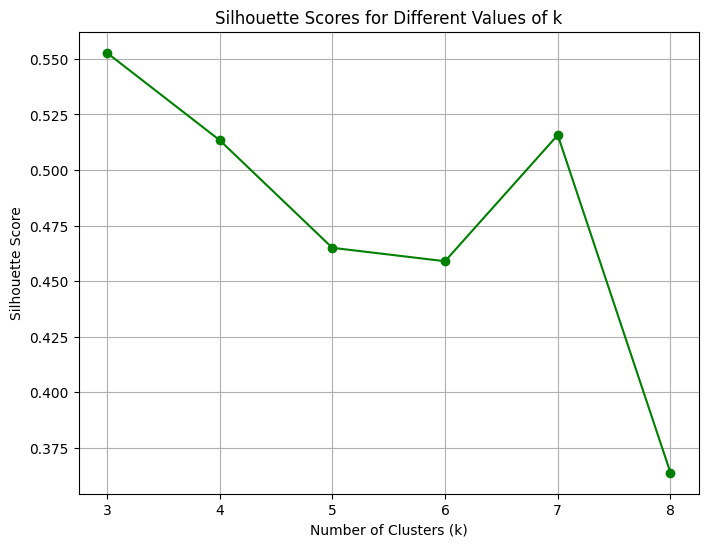

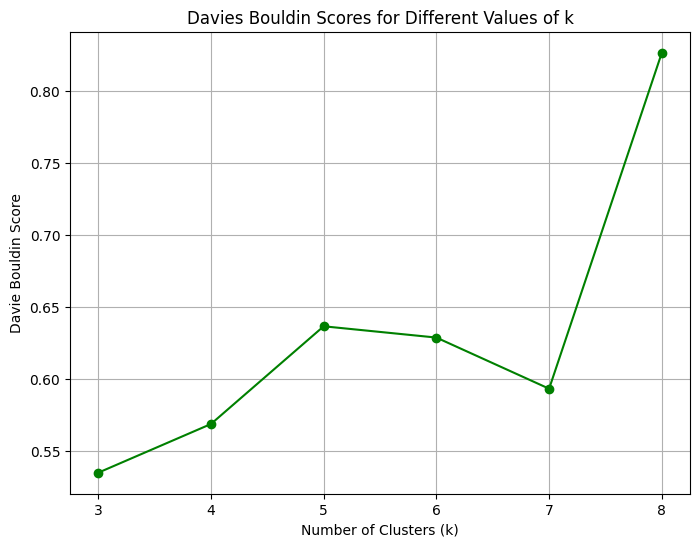

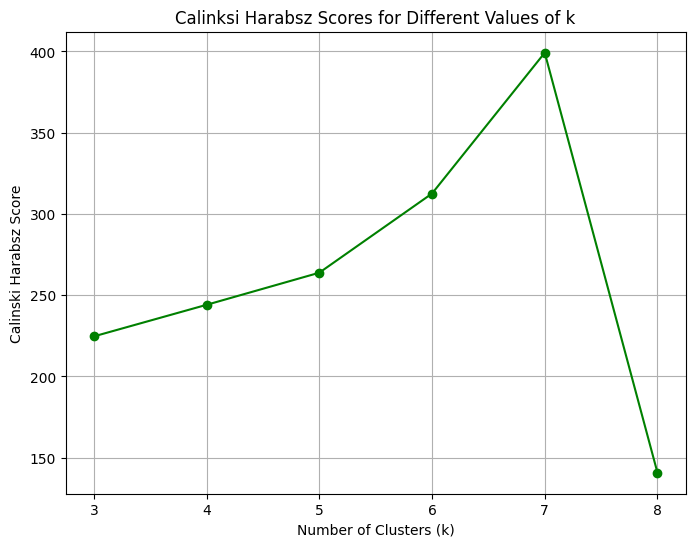

In [15]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

silhouette_scores = []
davies_bouldin_scores = []
calinski_harabsz_scores = []

for cluster, data in result_dictionary.items():
    features = data['features']
    cluster_labels = data['labels']

    curr_score =  silhouette_score(features, cluster_labels)
    silhouette_scores.append(curr_score)

    curr_score = davies_bouldin_score(features, cluster_labels)
    davies_bouldin_scores.append(curr_score)

    curr_score = calinski_harabasz_score(features, cluster_labels)
    calinski_harabsz_scores.append(curr_score)

# Plot the Silhouette Scores
plt.figure(figsize=(8,6))
plt.plot(k_values, silhouette_scores, marker='o', linestyle='-', color='g')
plt.title('Silhouette Scores for Different Values of k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

# Plot the Silhouette Scores
plt.figure(figsize=(8,6))
plt.plot(k_values, davies_bouldin_scores, marker='o', linestyle='-', color='g')
plt.title('Davies Bouldin Scores for Different Values of k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Davie Bouldin Score')
plt.grid(True)
plt.show()

# Plot the Silhouette Scores
plt.figure(figsize=(8,6))
plt.plot(k_values, calinski_harabsz_scores, marker='o', linestyle='-', color='g')
plt.title('Calinksi Harabsz Scores for Different Values of k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Calinski Harabsz Score')
plt.grid(True)
plt.show()

K value: 3
Silhouette Score: 0.5527604222297668
Davies-Bouldin Index: 0.5350192069348032
Calinski-Harabasz Index: 224.67813564776475


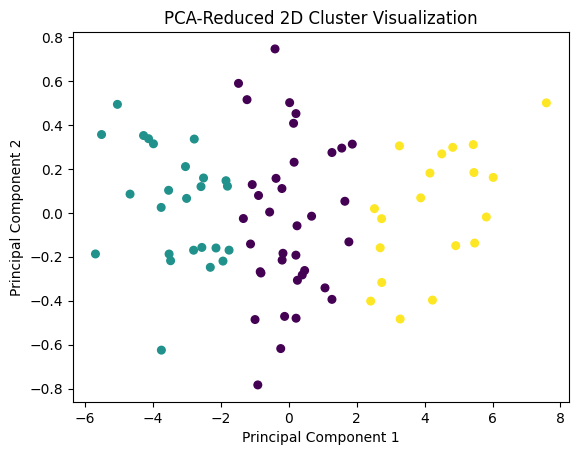

---------------------------------------------------------------------


In [18]:
best_kmeans = result_dictionary[3]

print(f"K value: {3}")
features = best_kmeans['features']
cluster_labels = best_kmeans['labels']

# Compute silhouette score
silhouette = silhouette_score(features, cluster_labels)  # X = feature matrix, labels = predicted cluster labels
print(f"Silhouette Score: {silhouette}")

# Compute davies bouldin socre
db_index = davies_bouldin_score(features, cluster_labels)
print(f"Davies-Bouldin Index: {db_index}")

# Compute calinski harabasz score 
ch_index = calinski_harabasz_score(features, cluster_labels)
print(f"Calinski-Harabasz Index: {ch_index}")

# Reduce to 2D
pca = PCA(n_components=2)
X_2D = pca.fit_transform(features)

plt.scatter(X_2D[:, 0], X_2D[:, 1], c=cluster_labels, cmap='viridis', s=30)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA-Reduced 2D Cluster Visualization')
plt.show()

# Song Reccomendation

The prediction process starts by loading the spectrogram image of a song and extracting its features using a pre-trained feature extractor model. These features are then passed to a KMeans model to predict the cluster label for the song, identifying its corresponding group. Finally, songs from the same cluster are retrieved as similar songs by comparing their predicted labels with those in the precomputed labels list.

In [47]:
test_song = f"C:/Users/Mario/Desktop/VSCODE/Spectrogram-Downloader/Spectrograms_{INPUT_SHAPE[0]}x{INPUT_SHAPE[1]}/Kali Uchis-After The Storm (feat. Tyler, The Creator & Bootsy Collins)_200x100.png"

img = load_image(test_song) 
song_name = 'Kali Uchis-After The Storm (feat. Tyler, The Creator & Bootsy Collins)'
# Load the feature extractor model
feature_extractor_path = best_kmeans['feature_extractor_path']
feature_extractor = tf.keras.models.load_model(feature_extractor_path)
print(f"Feature Extractor loaded from {feature_extractor_path}")

# Load the KMeans model
kmeans_path = best_kmeans['kmeans_path']
kmeans = joblib.load(kmeans_path)
print(f"KMeans model loaded from {kmeans_path}")

Feature Extractor loaded from models/feature_extractor_k_3.keras
KMeans model loaded from models/kmeans_k_3.pkl


In [49]:
feature = feature_extractor.predict(img, verbose=0)
predicted_label = kmeans.predict(feature)[0]
print(f"Predicted class for {song_name}: {predicted_label}")

Predicted class for Kali Uchis-After The Storm (feat. Tyler, The Creator & Bootsy Collins): 1


In [54]:
similar_songs = []
labels = best_kmeans['labels']

for i in range(0, len(labels)):
    if labels[i] == predicted_label:
        similar_songs.append(song_names[i])

print(f"Similar songs: {similar_songs}")

Similar songs: ['SZA-Snooze', 'SZA-All The Stars (with SZA)', "SiR-D'Evils", 'Baby Rose-Breaking Point', 'Orion Sun-These Days', 'SZA-Open Arms (feat. Travis Scott)', 'SiR-John Redcorn', 'SZA-Kill Bill', 'SZA-Saturn', 'Daniel Caesar-Always', 'SiR-Ooh Nah Nah (feat. Masego)', 'Baby Rose-In Your Arms', 'Mereba-GHOST RIDE', 'Daniel Caesar-Loose', 'Ella Mai-Shot Clock', 'Orion Sun-dirty dancer', 'Jhene Aiko-stranger', 'Ella Mai-Hearts On Deck', 'SZA-Good Days', 'Jhene Aiko-my mine', 'H.E.R.-Damage', 'Orion Sun-concrete', 'Orion Sun-Antidote', 'Baby Rose-Slow Burn', 'H.E.R.-Every Kind Of Way']
